In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime
import pandas as pd
import copy

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

In [2]:
import coronagraph as cg
import smart
#from jakely.plot import ColorTable

In [3]:
sys.path.insert(1, "../scripts")

import spectroscopy

In [4]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


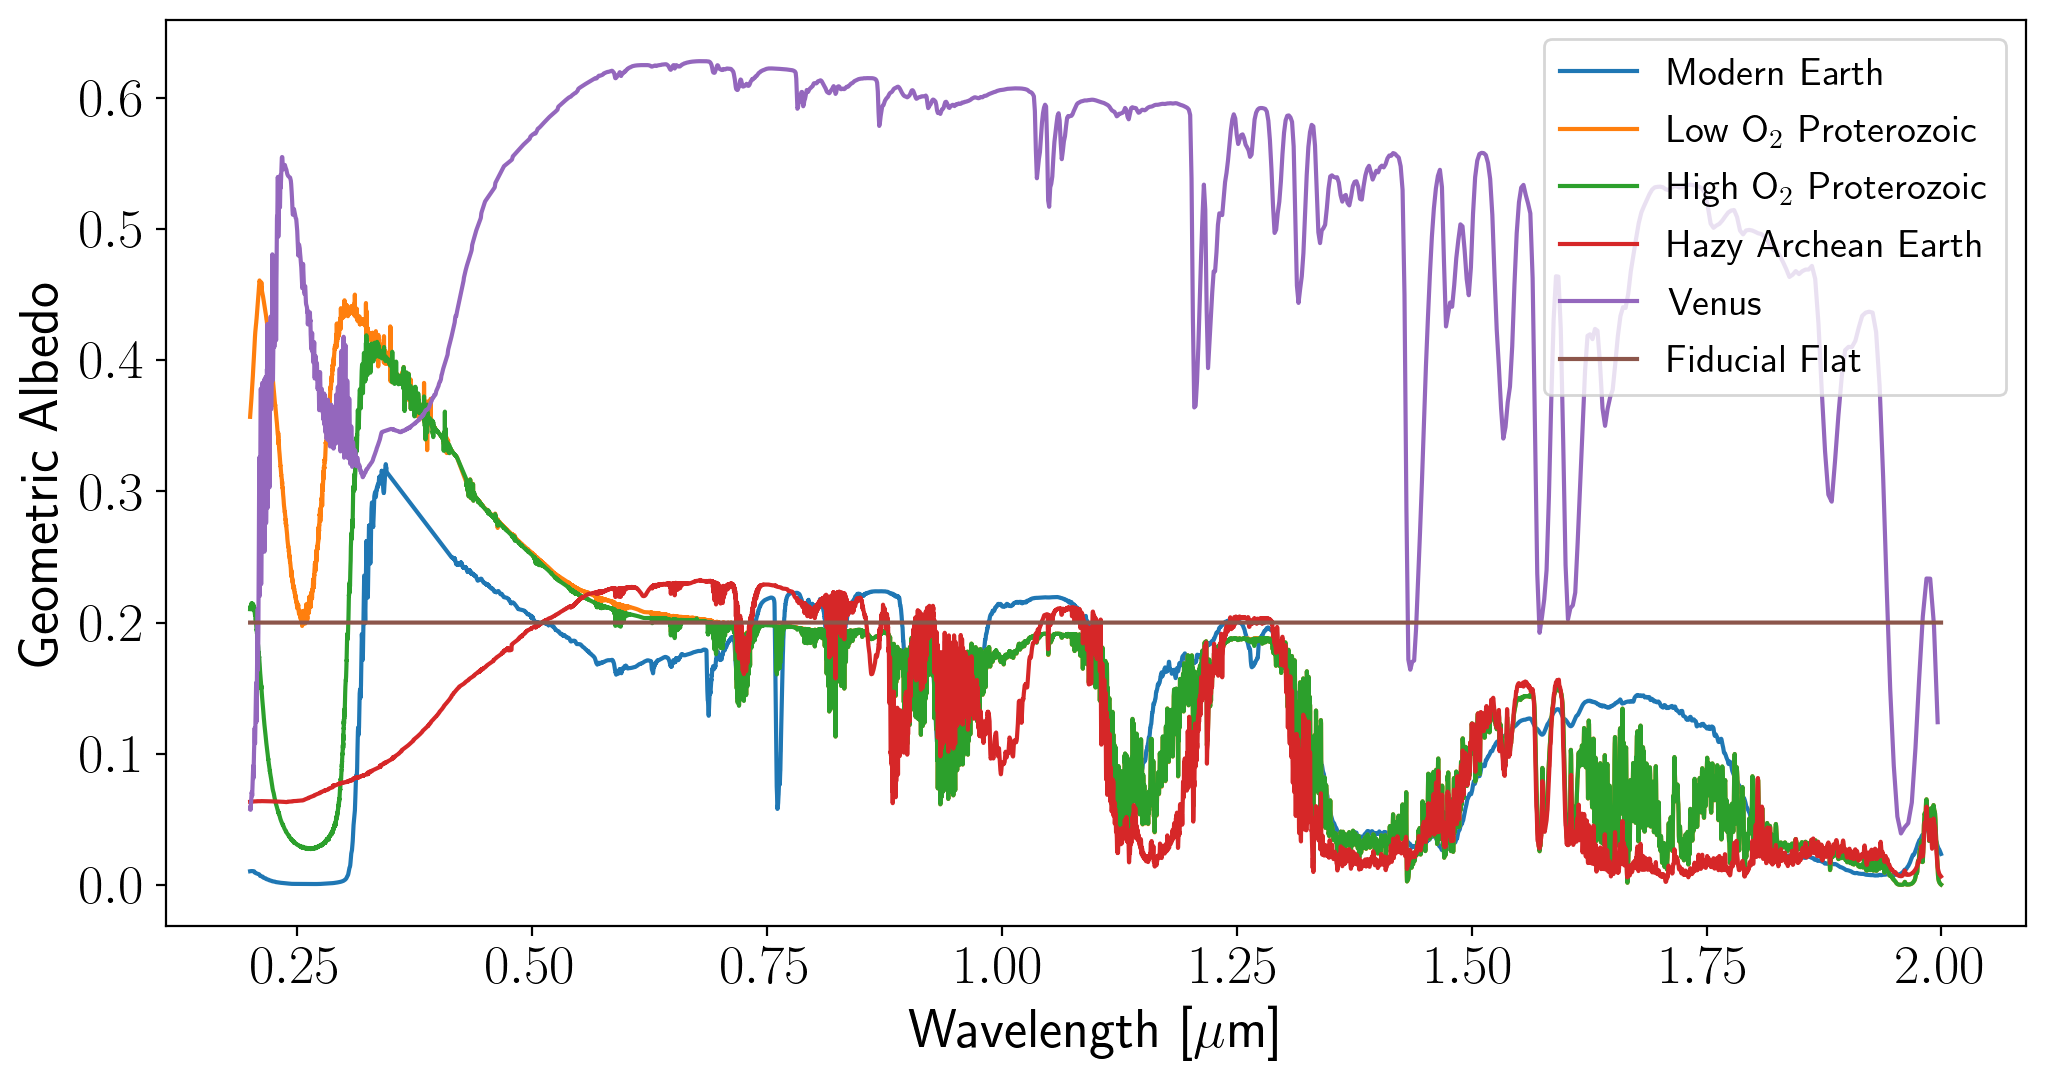

In [5]:
lammin = 0.2
lammax = 2.0

Ahr_flat = 0.2

lam_earth = spectroscopy.LAMHR[(spectroscopy.LAMHR > lammin) & (spectroscopy.LAMHR < lammax)]
ahr_earth = spectroscopy.AHR[(spectroscopy.LAMHR > lammin) & (spectroscopy.LAMHR < lammax)]
fs_earth = spectroscopy.FSTAR[(spectroscopy.LAMHR > lammin) & (spectroscopy.LAMHR < lammax)]

data = np.genfromtxt("../inputs/Hazy_ArcheanEarth_geo_albedo.txt")
lam_arch = data[:,0][(data[:,0] > lammin) & (data[:,0] < lammax)]
ahr_arch = data[:,1][(data[:,0] > lammin) & (data[:,0] < lammax)]
fs_arch = data[:,2][(data[:,0] > lammin) & (data[:,0] < lammax)]

data = np.genfromtxt("../inputs/proterozoic_low_o2_geo_albedo.txt")
lam_prol = data[:,0][(data[:,0] > lammin) & (data[:,0] < lammax)]
ahr_prol = data[:,1][(data[:,0] > lammin) & (data[:,0] < lammax)]
#fs_prol = data[:,2][(data[:,0] > lammin) & (data[:,0] < lammax)] # This looks wonky
fs_prol = np.interp(lam_prol, lam_earth, fs_earth)

data = np.genfromtxt("../inputs/proterozoic_hi_o2_geo_albedo.txt")
lam_proh = data[:,0][(data[:,0] > lammin) & (data[:,0] < lammax)]
ahr_proh = data[:,1][(data[:,0] > lammin) & (data[:,0] < lammax)]
#fs_proh = data[:,2][(data[:,0] > lammin) & (data[:,0] < lammax)] # This looks wonky
fs_proh = np.interp(lam_proh, lam_earth, fs_earth)

data = np.genfromtxt("../inputs/Venus_geo_albedo.txt")
lam_ven = data[:,0][(data[:,0] > lammin) & (data[:,0] < lammax)]
ahr_ven = data[:,1][(data[:,0] > lammin) & (data[:,0] < lammax)]
fs_ven = np.interp(lam_ven, lam_earth, fs_earth)

lam_flat = lam_earth
ahr_flat = Ahr_flat * np.ones_like(ahr_earth)
fs_flat = fs_earth

fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Geometric Albedo")

ax.plot(lam_earth, ahr_earth, label = "Modern Earth")
ax.plot(lam_prol, ahr_prol, label = "Low O$_2$ Proterozoic")
ax.plot(lam_proh, ahr_proh, label = "High O$_2$ Proterozoic")
ax.plot(lam_arch, ahr_arch, label = "Hazy Archean Earth")
ax.plot(lam_ven, ahr_ven, label = "Venus")
ax.plot(lam_flat, ahr_flat, label = "Fiducial Flat")

ax.legend(fontsize = 14)

In [6]:
drmA = spectroscopy.HEC_DRM(
    wantSNR = 8.5, 
    wantexp = 365., 
    Ahr_flat = 0.20,
    eta_int = 0.1, 
    bandwidth = [0.2, 0.2, 0.1], 
    architecture = "A", 
    telescope_mods = {}
)

#"""
name = "Modern Earth"
model_color = "C9"
drmA.LAMHR = lam_earth
drmA.AHR = ahr_earth
drmA.FSTAR = fs_earth
#"""

"""
name = "Hazy Archean Earth"
model_color = "orange"
drmA.LAMHR = lam_arch
drmA.AHR = ahr_arch
drmA.FSTAR = fs_arch
"""

"""
name = "High O$_2$ Proterozoic"
model_color = "C0"
drmA.LAMHR = lam_proh
drmA.AHR = ahr_proh
drmA.FSTAR = fs_proh
"""

"""
name = r"Low O$_2$ Proterozoic Earth"
model_color = "purple"
drmA.LAMHR = lam_prol
drmA.AHR = ahr_prol
drmA.FSTAR = fs_prol
"""

"""
name = "Venus"
model_color = "C3"
drmA.LAMHR = lam_ven
drmA.AHR = ahr_ven
drmA.FSTAR = fs_ven
"""

"""
name = "Fiducial %i\%% Albedo" %(100*Ahr_flat)
model_color = "C7"
drmA.LAMHR = lam_flat
drmA.AHR = ahr_flat
drmA.FSTAR = fs_flat
"""

drmA.generate_exptime_table()

/Users/lustija1/Projects/coronagraph/coronagraph/count_rates.py:314: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/lustija1/Projects/coronagraph/coronagraph/count_rates.py:315: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt
../scripts/spectroscopy.py:1400: RuntimeWarning: divide by zero encountered in double_scalars
  t_snr = (wantsnr**2 - intercept) / slope
/Users/lustija1/Projects/coronagraph/coronagraph/count_rates.py:311: RuntimeWarning: invalid value encountered in multiply
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)
/Users/lustija1/Projects/coronagraph/coronagraph/count_rates.py:311: RuntimeWarning: invalid value encountered in true_divide
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)


No exact match found
Using F3V for F3Vwvar
No exact match found
Using F5IV for F5IV-V
No exact match found
Using G8V for G8Vp
No exact match found
Using K5V for K5
No exact match found
Using K4V for K4Vp
No exact match found
Using G8IV for G8IV-V
No exact match found
Using K5V for K5
No exact match found
Using G8V for G8Vvar
No exact match found
Using G5V for G3/G5V
No exact match found
Using F7IV for F7IV-V
No exact match found
Using G8IV for G8IVvar


/Users/lustija1/Projects/coronagraph/coronagraph/noise_routines.py:1042: RuntimeWarning: invalid value encountered in greater
  i = (cp > 0.)
/Users/lustija1/Projects/coronagraph/coronagraph/noise_routines.py:1043: RuntimeWarning: invalid value encountered in less_equal
  j = (cp <= 0.0)


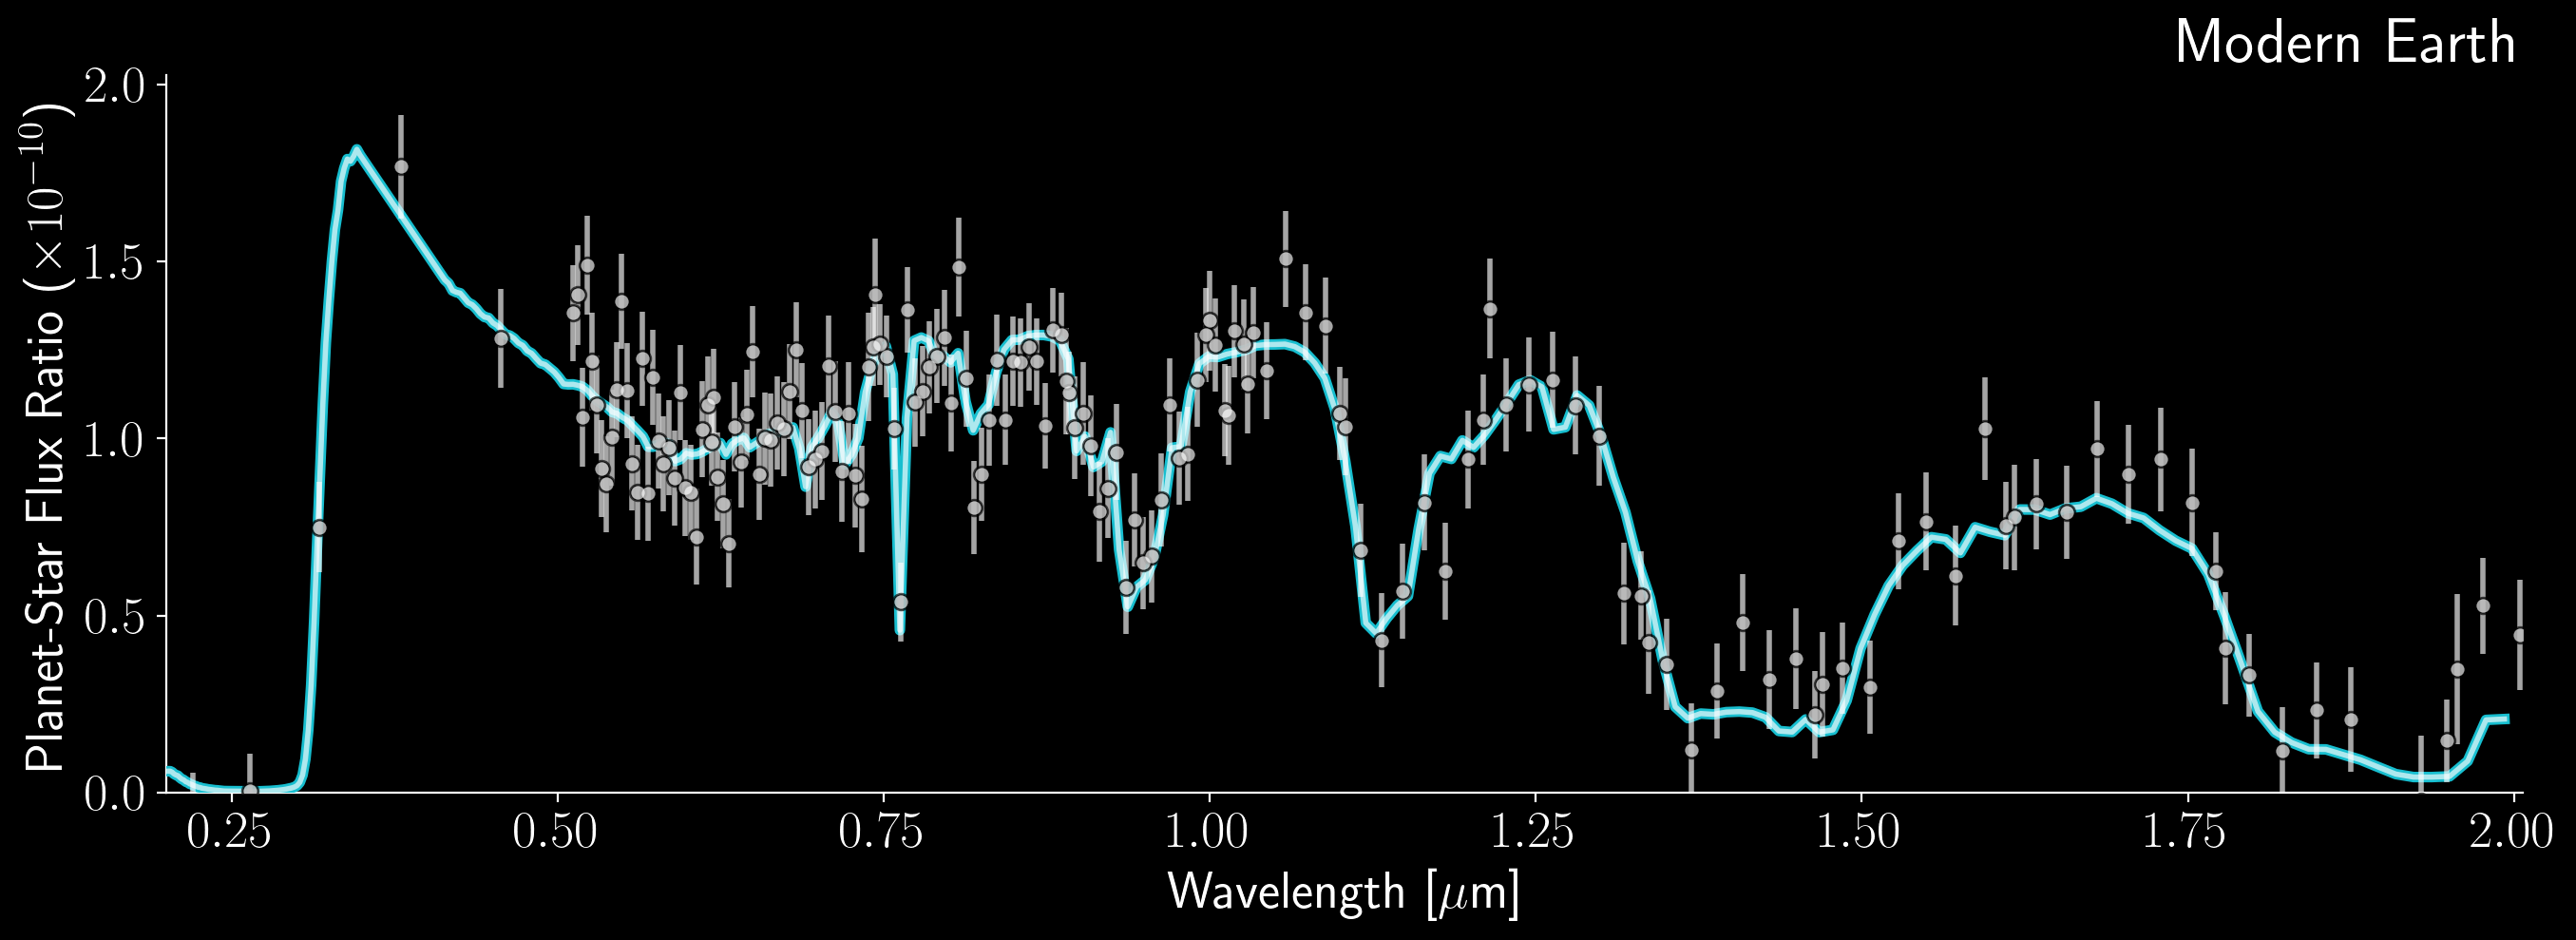

In [7]:
# Set planet and star parameters for an Earth-Sun analog at 5pc
drmA.cn.planet.distance = 7.0
drmA.cn.planet.a = 1.0
drmA.cn.star.Rs = 1.0
drmA.cn.star.Teff = 5780.
drmA.cn.SILENT = False

output = drmA.complete_spectrum_time(plot=False)

spectrum = output[2]

iremove = []
cc = ["C0", "C2", "C3"]
model_color = model_color

with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'figure.facecolor' : 'black', 
                     'axes.facecolor' : 'None', 'text.color' : 'white', 'axes.labelcolor' : 'white', 
                     'axes.edgecolor' : 'white'}):

    fig, ax = plt.subplots(figsize = (16,5))
    ax.set_xlabel("Wavelength [$\mu$m]")
    ax.set_ylabel(r"Planet-Star Flux Ratio ($\times 10^{-10}$)")
    ax.set_title(name, pad = -25, loc = "right")

    for i in range(len(drmA.bp_names)):
        if i not in iremove:
            ax.plot(spectrum[0][i], 1e10*spectrum[3][i], "o", ms = 6.0, alpha = 0.65, color = "black", zorder = 80)
            ax.errorbar(spectrum[0][i], 1e10*spectrum[3][i], yerr=1e10*spectrum[4][i], fmt = "o", ms = 5.0, alpha = 0.65, color = "white", zorder = 80, mew = 0.1, elinewidth=2.0)
            #ax.axvspan(drmA.bandpasses[i][0], drmA.bandpasses[i][1], alpha = 0.2, color = cc[drmA.bp_chan[i]])

    drmA.cn.telescope.lammin = 0.2
    drmA.cn.telescope.lammax = 2.0
    drmA.cn.telescope.resolution = 140.
    # Re-do count rate calcs for true Earth spectrum
    drmA.cn.run_count_rates(drmA.AHR, drmA.LAMHR, drmA.FSTAR)
    ax.plot(drmA.cn.lam, 1e10*drmA.cn.Cratio, color = model_color, zorder = 70, lw = 4.0, alpha = 1.)
    ax.plot(drmA.cn.lam, 1e10*drmA.cn.Cratio, color = "w", zorder = 70, lw = 2.0, alpha = 0.65)
    ax.set_ylim(bottom=0.0)
    ax.set_xlim(drmA.cn.lam.min(), drmA.cn.lam.max())
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #img = plt.imread("/Users/Jake/Desktop/archean.jpg")
    #ax.imshow(img, extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], aspect='auto')
    
    #fig.savefig("/Users/Jake/Dropbox/Astronomy/UW/Astrobio/Research Rotation/LUVOIR/figures_new/exoEarthDRM_spectrum2_"+name.replace(" ", "_")+".pdf", bbox_inches = "tight", facecolor = "black")
    #fig.savefig("/Users/Jake/Dropbox/Astronomy/UW/Astrobio/Research Rotation/LUVOIR/figures_new/exoEarthDRM_spectrum2_"+name.replace(" ", "_")+"_transparant.pdf", bbox_inches = "tight", facecolor = 'None', transparant = True)
    

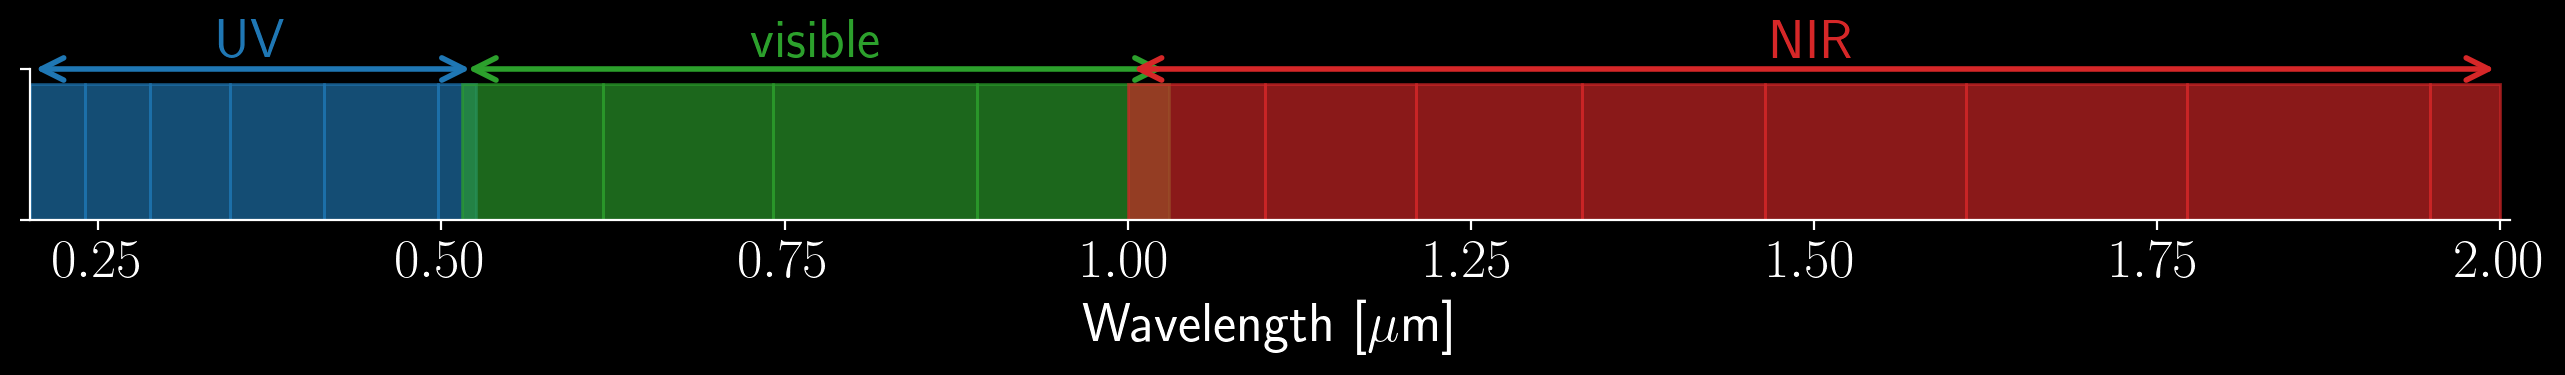

In [9]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'figure.facecolor' : 'black', 
                     'axes.facecolor' : 'None', 'text.color' : 'white', 'axes.labelcolor' : 'white', 
                     'axes.edgecolor' : 'white'}):

    fig, ax = plt.subplots(figsize = (16,1))
    ax.set_xlabel("Wavelength [$\mu$m]")
    #ax.set_ylabel(r"Planet-Star Flux Ratio ($\times 10^{-10}$)")

    for i in range(len(drmA.bp_names)):
        if i not in iremove:
            #ax.plot(spectrum[0][i], 1e10*spectrum[3][i], "o", ms = 4.0, alpha = 0.65, color = "black", zorder = 80)
            #ax.errorbar(spectrum[0][i], 1e10*spectrum[3][i], yerr=1e10*spectrum[4][i], fmt = "o", ms = 2.0, alpha = 0.65, color = "white", zorder = 80)
            ax.axvspan(drmA.bandpasses[i][0], drmA.bandpasses[i][1], ymax = 0.9, alpha = 0.65, color = cc[drmA.bp_chan[i]])

    #drmA.cn.telescope.lammin = 0.2
    #drmA.cn.telescope.lammax = 2.0
    #drmA.cn.telescope.resolution = 140.
    ## Re-do count rate calcs for true Earth spectrum
    #drmA.cn.run_count_rates(drmA.AHR, drmA.LAMHR, drmA.FSTAR)
    #ax.plot(drmA.cn.lam, 1e10*drmA.cn.Cratio, color = model_color, zorder = 70, lw = 4.0, alpha = 1.)
    #ax.plot(drmA.cn.lam, 1e10*drmA.cn.Cratio, color = "w", zorder = 70, lw = 2.0, alpha = 0.65)
    #ax.set_ylim(bottom=0.0)
    ax.set_xlim(drmA.cn.lam.min(), drmA.cn.lam.max())
    ax.set_yticklabels([])
    
    yloc = 1.00
    
    lammin_inst = drmA.bandpasses[drmA.bp_chan == 0][0][0]
    lammax_inst = drmA.bandpasses[drmA.bp_chan == 0][-1][1]
    xloc = (lammax_inst + lammin_inst) / 2
    name = "UV"
    color = cc[0]
    bbox_fc = "w"
    ax.annotate(s='', xy=(lammin_inst,yloc), xytext=(lammax_inst,yloc), arrowprops=dict(arrowstyle='<->', color=color, lw = 2.0), zorder=100)
    ax.text(xloc, yloc, name, ha="center", va="bottom", color=color, zorder=99)#, bbox=dict(boxstyle="square", fc=bbox_fc, ec="none", zorder=2))

    lammin_inst = drmA.bandpasses[drmA.bp_chan == 1][0][0]
    lammax_inst = drmA.bandpasses[drmA.bp_chan == 1][-1][1]
    xloc = (lammax_inst + lammin_inst) / 2
    name = "visible"
    color = cc[1]
    bbox_fc = "w"
    ax.annotate(s='', xy=(lammin_inst,yloc), xytext=(lammax_inst,yloc), arrowprops=dict(arrowstyle='<->', color=color, lw = 2.0), zorder=100)
    ax.text(xloc, yloc, name, ha="center", va="bottom", color=color, zorder=99)#, bbox=dict(boxstyle="square", fc=bbox_fc, ec="none", zorder=2))

    lammin_inst = drmA.bandpasses[drmA.bp_chan == 2][0][0]
    lammax_inst = drmA.bandpasses[drmA.bp_chan == 2][-1][1]
    xloc = (lammax_inst + lammin_inst) / 2
    name = "NIR"
    color = cc[2]
    bbox_fc = "w"
    ax.annotate(s='', xy=(lammin_inst,yloc), xytext=(lammax_inst,yloc), arrowprops=dict(arrowstyle='<->', color=color, lw = 2.0), zorder=100)
    ax.text(xloc, yloc, name, ha="center", va="bottom", color=color, zorder=99)#, bbox=dict(boxstyle="square", fc=bbox_fc, ec="none", zorder=2))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #img = plt.imread("/Users/Jake/Desktop/archean.jpg")
    #ax.imshow(img, extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], aspect='auto')
    
    #fig.savefig("/Users/Jake/Dropbox/Astronomy/UW/Astrobio/Research Rotation/LUVOIR/figures_new/exoEarthDRM_spectrum_channels.pdf", bbox_inches = "tight", facecolor = "black")
    #fig.savefig("/Users/Jake/Dropbox/Astronomy/UW/Astrobio/Research Rotation/LUVOIR/figures_new/exoEarthDRM_spectrum_channels_transparant.pdf", bbox_inches = "tight", facecolor = 'None', transparant = True)

/Users/lustija1/Projects/coronagraph/coronagraph/noise_routines.py:1042: RuntimeWarning: invalid value encountered in greater
  i = (cp > 0.)
/Users/lustija1/Projects/coronagraph/coronagraph/noise_routines.py:1043: RuntimeWarning: invalid value encountered in less_equal
  j = (cp <= 0.0)


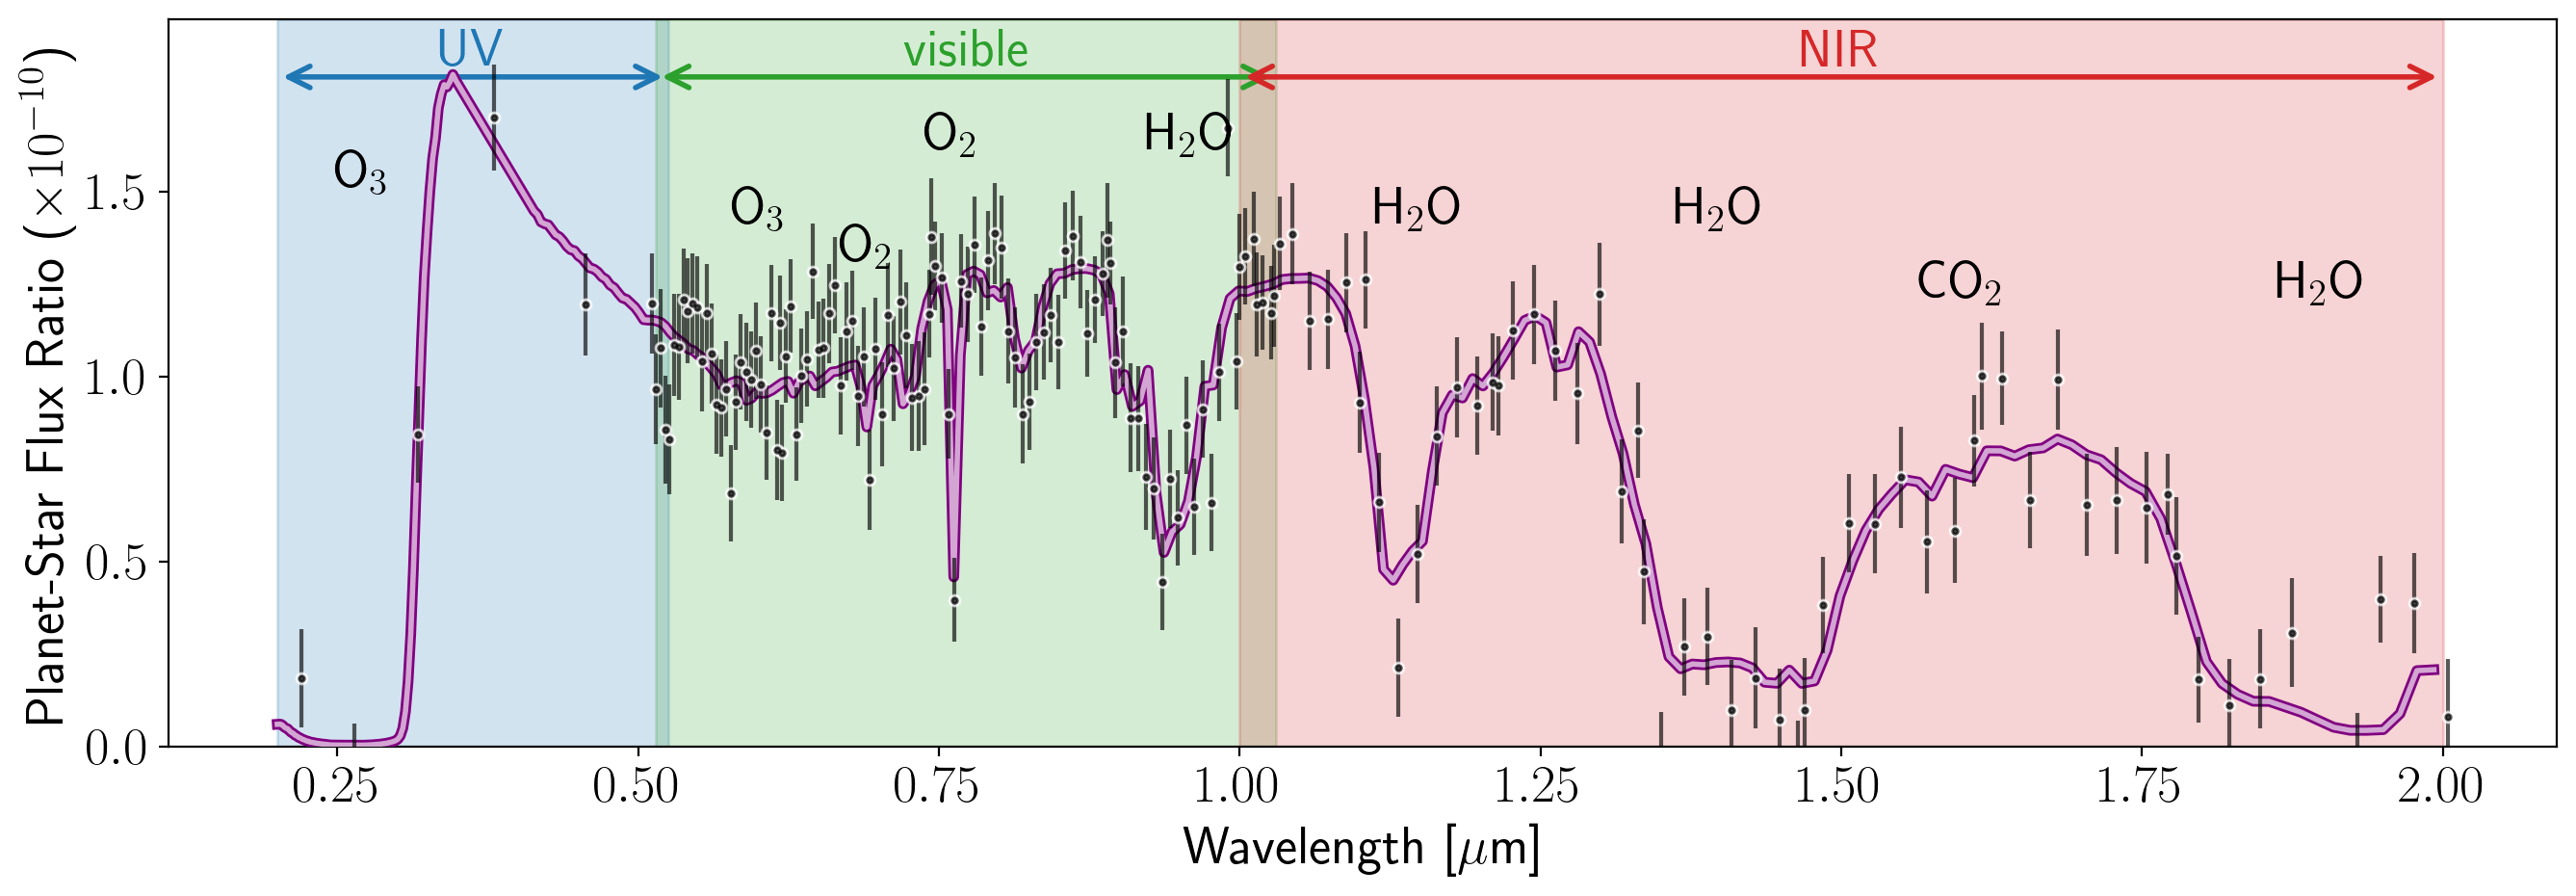

In [23]:
# Figure for Aki on 9/21/20
fig, ax = drmA.plot_observed_spectrum(show_bandpasses=False, yloc = 1.81)
fig.savefig("../plots/exoEarthDRM_Earth_spectrum_channels.pdf", bbox_inches = "tight", facecolor = "white")

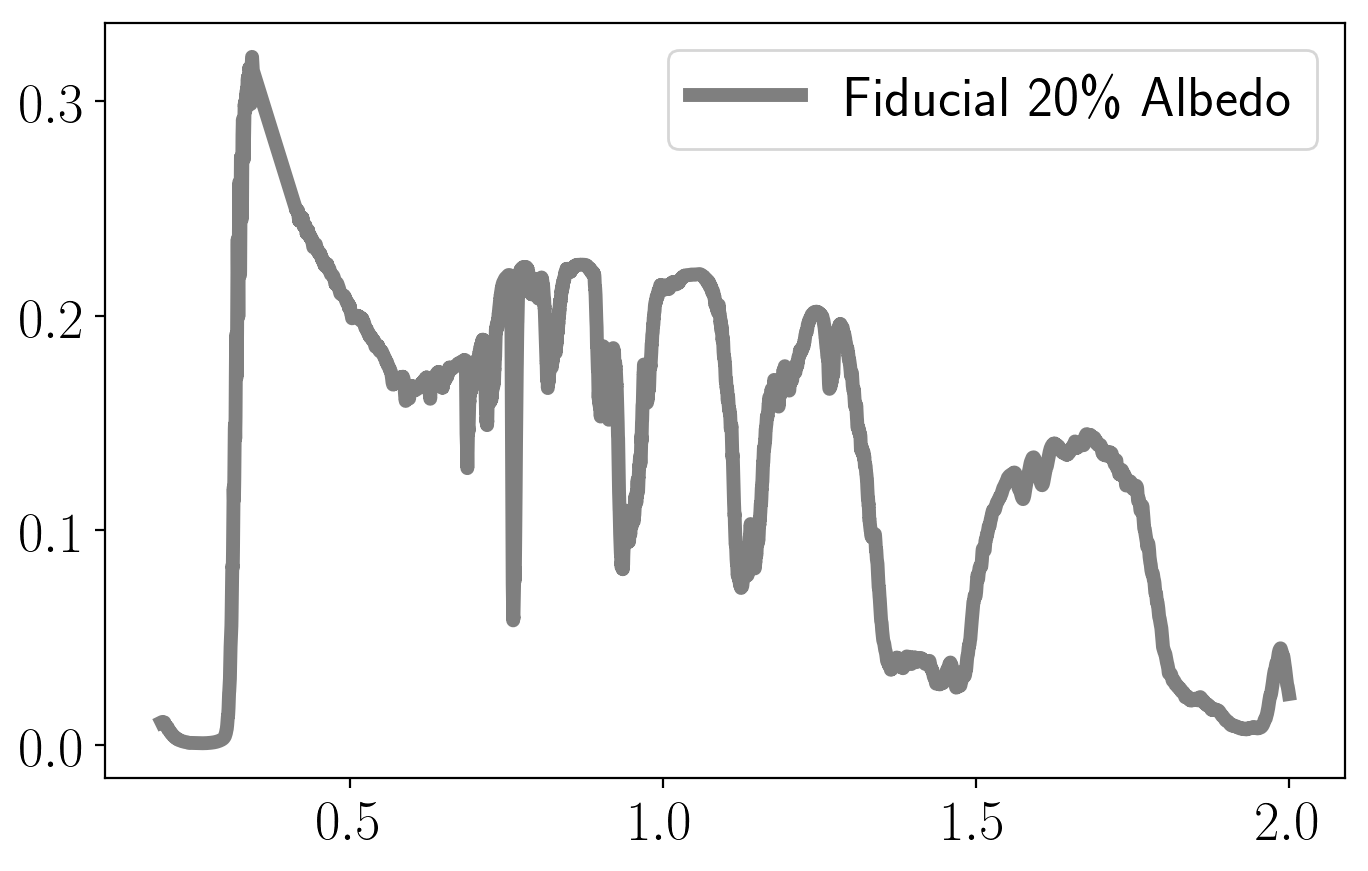

In [144]:
plt.plot(lam_earth, ahr_earth, color = "C7", lw = 5.0, label = "Fiducial %i\%% Albedo" %(100*Ahr_flat))
plt.legend()


# Make data file of spectrum

In [61]:
lamlr = []
ytru= []
yobs = []
yerr = []
ibp = []
ichan = []

for i in range(len(drmA.bp_names)):
    lamlr.append(spectrum[0][i]) 
    ytru.append(spectrum[2][i]) 
    yobs.append(spectrum[3][i]) 
    yerr.append(spectrum[4][i])
    ibp.append((i+1)*np.ones(len(spectrum[0][i])))
    ichan.append((drmA.bp_chan[i]+1)*np.ones(len(spectrum[0][i])))
    
lamlr = np.hstack(lamlr)
yobs = np.hstack(yobs)
ytru = np.hstack(ytru)
yerr = np.hstack(yerr)
ibp = np.array(np.hstack(ibp), dtype=int)
ichan = np.array(np.hstack(ichan), dtype=int)

In [62]:
ibp

array([ 1,  2,  3,  4,  5,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16,
       16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18])

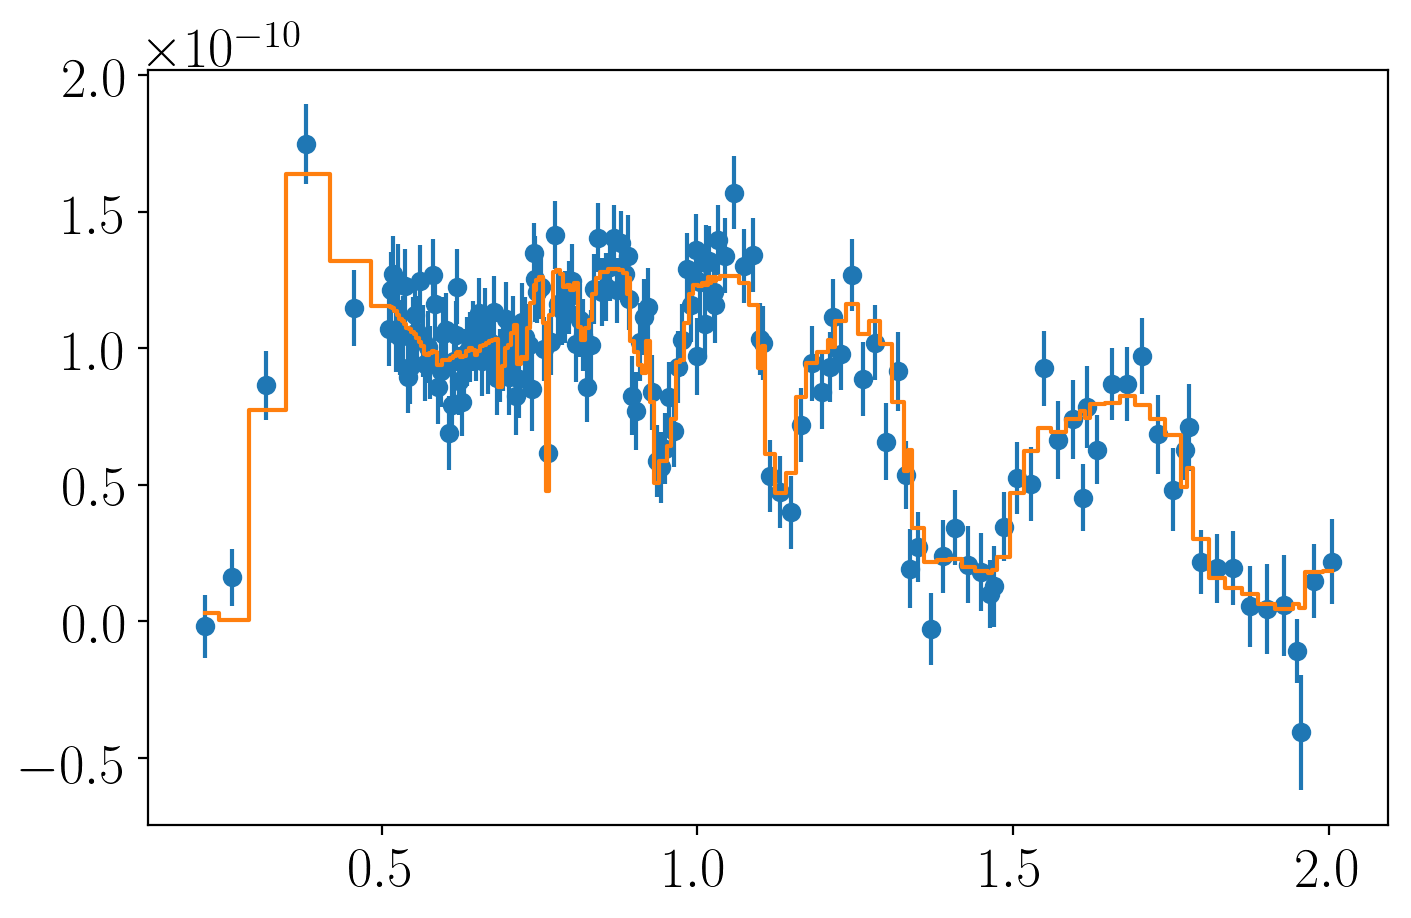

In [63]:
plt.errorbar(lamlr, yobs, yerr=yerr, fmt="o", zorder = 1)
plt.plot(lamlr, ytru, ls = "steps-mid")

In [72]:
len(drmA.bandpasses[:,0])

18

In [64]:
data = np.vstack([lamlr, ytru, yobs, yerr, ichan, ibp])

np.savetxt("/Users/Jake/Desktop/luvoir_earth_data.txt", data.T, 
           fmt=['%0.5e', '%0.5e', '%0.5e', '%0.5e', '%i', '%i'], 
           comments="", delimiter = "    ", header = "wl[um]         Fp/Fs(true)    Fp/Fs(obs)     Err(obs)     iChan   iBP")


In [83]:
data = np.vstack([1+np.arange(len(drmA.bp_chan)), drmA.bandpasses[:,0], drmA.bandpasses[:,1]])

In [84]:
np.savetxt("/Users/Jake/Desktop/luvoir_bandpass_data.txt", data.T, 
           fmt=['%i', '%.3f', '%.3f'], 
           comments="", delimiter = "    ", header = "iBP   left    right")
